In [2]:
# General tools - Data Structures
import numpy as np
import scipy as sp
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error as mae

# Curve fitting
from scipy.optimize import curve_fit #<! See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

# For the tree visualization
import pydot
from IPython.display import Image, display
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

# Used Cars Case

In this notebook we'll do a full analysis of the prediction of cars price using regression based on diamonds example.

> **Note:** The first chapter of this notebook (The data) follows the steps already discussed in the [SciKit Learn Pipeline Notebook](https://drive.google.com/drive/u/1/folders/1Z8hZpqnmlhBkwRXFIS7R-XlhmubOx_6z), but with some extra details. If you are familiar with them, you may swiftly run through it and continue with the modeling part below.

#The Problem

Predicting the price of a used car in India. Price is in INR Lakhs 1 Lakhs = 100,000 INR or 1,356 USD

## The Data

The dataset is from Kaggle: https://www.kaggle.com/colearninglounge/used-cars-price-prediction/download (`cars.csv`).

## The Scoring

The scoring will be measured by MAE.

## Get the Data

In [3]:
cars = pd.read_csv('cars.csv')
cars.sample(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2699,Audi Q3 35 TDI Quattro Premium Plus,Bangalore,2015,51000,Diesel,Automatic,First,15.17 kmpl,1968 CC,181 bhp,5.0,48.64 Lakh,27.50
6010,Honda Brio 1.2 VX MT,Delhi,2013,33746,Petrol,Manual,First,18.5 kmpl,1198 CC,86.8 bhp,5.0,6.63 Lakh,3.20
4880,Maruti Wagon R LXI,Kochi,2014,52431,Petrol,Manual,First,22.5 kmpl,998 CC,67.04 bhp,5.0,4.59 Lakh,3.01
1596,Audi Q7 4.2 FSI quattro,Delhi,2008,71000,Petrol,Automatic,First,8.3 kmpl,4134 CC,250 bhp,7.0,NaN,11.99
3486,Toyota Fortuner 3.0 Diesel,Delhi,2011,62100,Diesel,Manual,First,11.5 kmpl,2982 CC,171 bhp,7.0,NaN,10.75
1332,Maruti Wagon R CNG LXI,Pune,2013,79494,CNG,Manual,First,33.54 km/kg,998 CC,67.04 bhp,5.0,5.54 Lakh,2.96
4614,BMW X5 X5 M,Chennai,2017,15000,Diesel,Automatic,First,15.97 kmpl,2993 CC,258 bhp,5.0,NaN,70.00
4301,Maruti Vitara Brezza ZDi Plus Dual Tone,Pune,2016,47300,Diesel,Manual,First,24.3 kmpl,1248 CC,88.5 bhp,5.0,11.96 Lakh,8.85
2591,Hyundai i20 2015-2017 Magna 1.2,Pune,2016,20600,Petrol,Manual,First,18.6 kmpl,1197 CC,81.83 bhp,5.0,NaN,5.40
3784,Toyota Innova Crysta 2.8 ZX AT,Kochi,2017,26023,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,7.0,26.55 Lakh,19.97


In [4]:
# atms.shape
cars.shape

(6019, 13)

> **Note:** If you do not remember the dataset, then this is a good point for some [EDA of the diamonds dataset](https://drive.google.com/drive/folders/15R3HlPj92TG285UpBvPEVNCLO8h2_pIf?usp=sharing).

## Cleaning

This step makes sure only relevant data is collected.

In [5]:
cars.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price'],
      dtype='object')

In [6]:
test = cars.Kilometers_Driven.isnull() == True
print(test)

0       False
1       False
2       False
3       False
4       False
        ...  
6014    False
6015    False
6016    False
6017    False
6018    False
Name: Kilometers_Driven, Length: 6019, dtype: bool


### Dropping Non Physical Diamonds

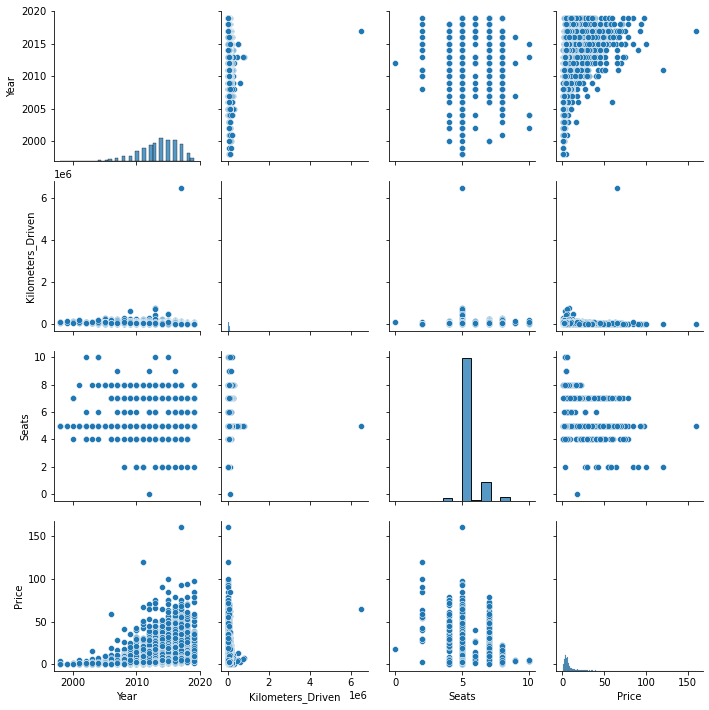

In [7]:
sns.pairplot(cars)

In [8]:
#Drop zero parameters
def drop_zeros(df):
  return cars.loc[cars.Kilometers_Driven *cars.Mileage !=0]
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)
cars = zeros_dropper.fit_transform(cars)
display(cars.shape)

(6019, 13)

In [9]:
cars.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price'],
      dtype='object')

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


In [11]:
cars = cars.drop('New_Price', axis=1)

In [12]:
cars.Price.count(level=None)

6019

In [13]:
cars.Owner_Type.count(level=None)

6019

In [14]:
cars.Price.mean()

9.479468350224273

### Removing cars with unrealistic values

### Removing Outliers

#### 6 Sigma ($ \sigma $) Range

For illustration purposes we illustrate a simple and common outlier removing technique, based on keeping the values between 3 times the standard deviation. Many times it is advisable to apply a more robust process.

In [15]:
sigmaFactor = 3 #<! It is popular to use 3 Sigma

for col in cars.columns:
    if cars[col].dtype == 'int64':
        std = cars[col].std()
        ave = cars[col].mean()
        cars = cars.loc[cars[col].between(ave - (sigmaFactor * std), ave + (sigmaFactor * std))] #<! See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.between.html
        print(f'Processing {col:10} --> {cars.shape[0]:5} cars remain')

Processing Year       -->  5969 cars remain
Processing Kilometers_Driven -->  5962 cars remain


In [16]:
sigmaFactor = 3 #<! It is popular to use 3 Sigma

for col in cars.columns:
    if cars[col].dtype == 'float64':
        std = cars[col].std()
        ave = cars[col].mean()
        cars = cars.loc[cars[col].between(ave - (sigmaFactor * std), ave + (sigmaFactor * std))] #<! See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.between.html
        print(f'Processing {col:10} --> {cars.shape[0]:5} cars remain')

Processing Seats      -->  5768 cars remain
Processing Price      -->  5621 cars remain


In [17]:
cars.Price.median()

5.5

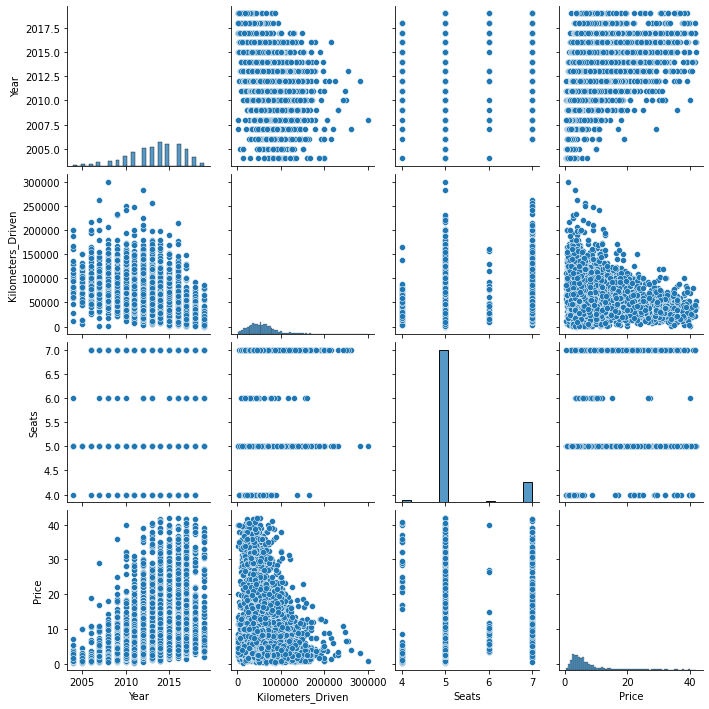

In [18]:
sns.pairplot(cars)

#### Questionable Data

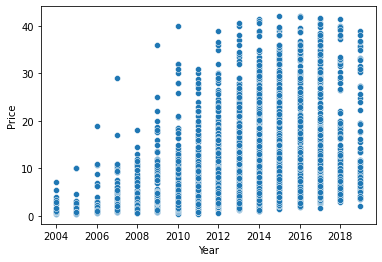

In [19]:
sns.scatterplot(x='Year', y='Price', data=cars)


---



---



---



In [20]:
kmed = cars.Kilometers_Driven.median()
print(f'Median driven kilometers: {kmed}')
kmin = cars.Kilometers_Driven.min()
print(f'Min driven kilometers: {kmin}')
kmax = cars.Kilometers_Driven.max()
print(f'Max driven kilometers: {kmax}')

Median driven kilometers: 53000.0
Min driven kilometers: 171
Max driven kilometers: 300000


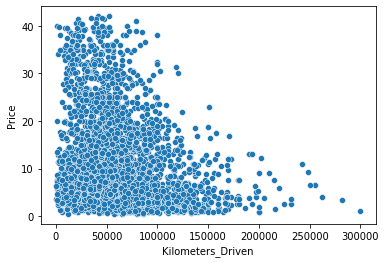

In [21]:

sns.scatterplot(y='Price', x='Kilometers_Driven', data=cars)

Cars median price is: 5.5


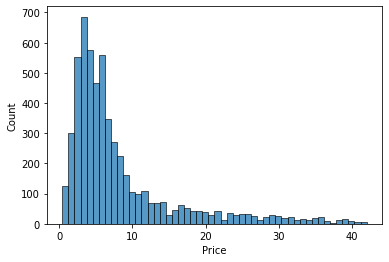

In [22]:
#price bins
sns.histplot(x='Price', data=cars,bins=50)
Cmean = round(cars.Price.median(),2)
print(f'Cars median price is: {Cmean}')

<font color='blue'>(**!**)</font> Create a linear model for predicting `z` from `x` ([Short reminder](https://www.mathsisfun.com/algebra/line-equation-2points.html) to those who forgot how to do it), and then remove every data point with $abs(\hat{z}_i-z_i)>\epsilon$.

#### More Questionable Data

Relation between price and Year, Owner_Type and Kilometers Driven. 

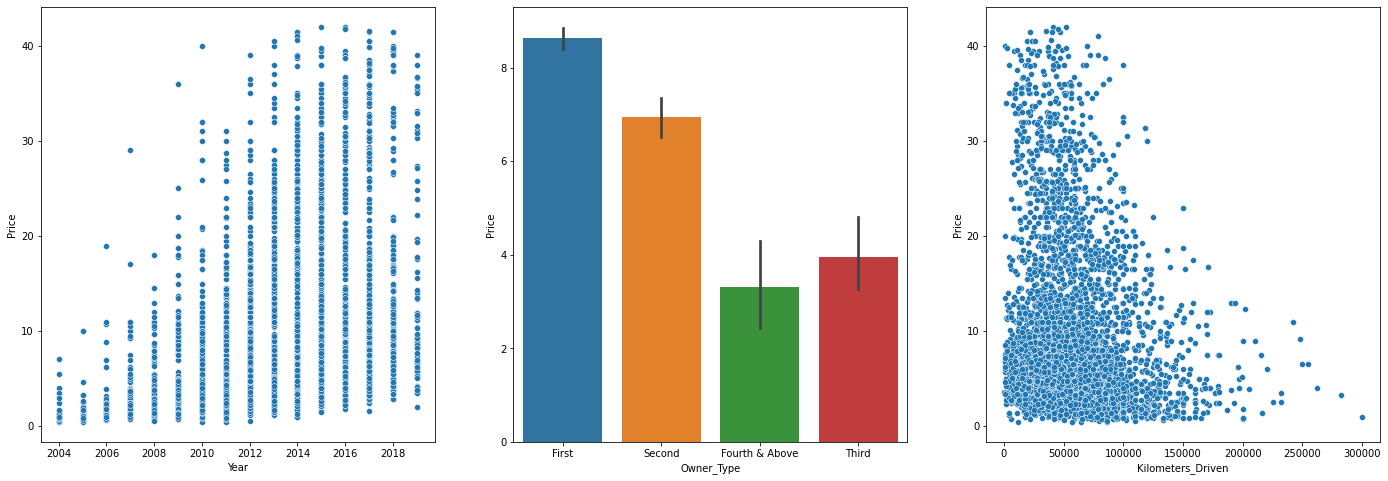

In [23]:
hFig, (hAxes1, hAxes2, hAxes3) = plt.subplots(1, 3, figsize = (24, 8))

sns.scatterplot(x='Year', y='Price', data=cars, ax=hAxes1)
sns.barplot(x='Owner_Type', y='Price', data=cars, ax=hAxes2)
sns.scatterplot(x='Kilometers_Driven', y='Price', data=cars, ax=hAxes3)

## Feature Selection

For many practical reasons, and also due to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning), it is always a good idea to reduce the number of features. One of the methods of doing that is by removing features completely.

### Relevance

Very often, some of the features are irrelevant for the problem and can be removed. 

Other methods involve statistics in order to score the relevancy of some features (e.g. [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). We will skip this for now.

### Correlation

Many times columns are closely related to other columns and therefore can be dropped. This is usually more relevant to numerical data, so we use [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html).

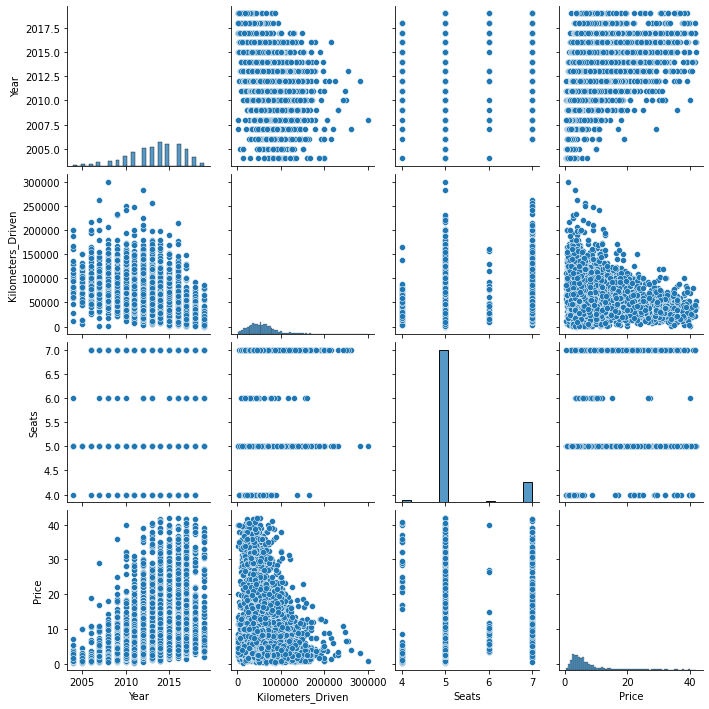

In [24]:
cars_num = cars.select_dtypes(include=np.number)
sns.pairplot(cars_num, height=2.5)

In [25]:
cars.corr()

,Year,Kilometers_Driven,Seats,Price
Year,1.000000,-0.495505,0.076084,0.319031
Kilometers_Driven,-0.495505,1.000000,0.187993,-0.145229
Seats,0.076084,0.187993,1.000000,0.188101
Price,0.319031,-0.145229,0.188101,1.000000


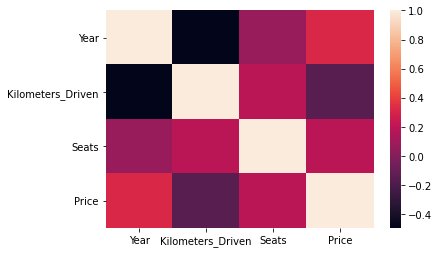

In [26]:
sns.heatmap(cars.corr())

Due to the high correlation we decide to drop all dimensions besides the 

1.   List item

1.   List item

1.   List item
2.   List item


2.   List item


2.   List item

`carat`.

## Preprocessing

In [27]:
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


### Scaling

#### Features

For many reasons, it is often advisable to scale the features. One of the reasons is to make sure that none of the featrues "shadows" the others.

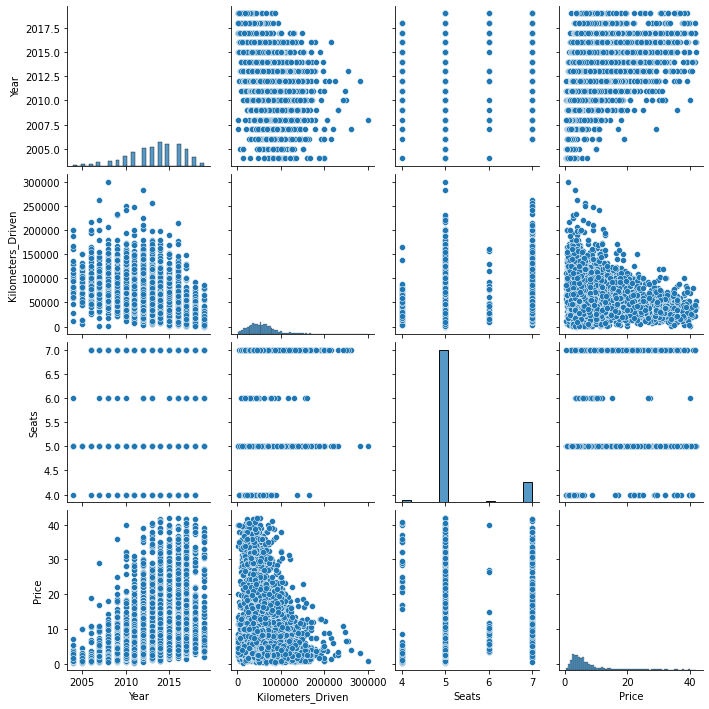

In [28]:
cars_num = cars.select_dtypes(include=np.number)
sns.pairplot(cars_num, height=2.5)

#### Target

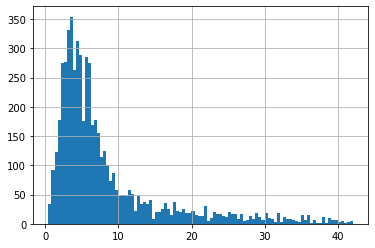

In [29]:
cars.Price.hist(bins=100)

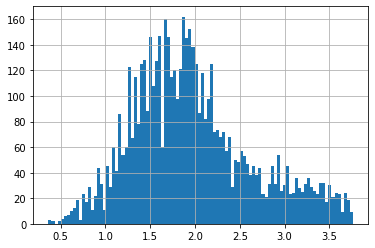

In [30]:
log_price = np.log1p(cars.Price)
log_price.hist(bins=100)

In [31]:
# cars.price = log_price
# cars.rename({'Price': 'log_price'}, inplace=True, axis=1)
# cars.head()

In [32]:
manufacturers = ['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota', 'Volkswagen', 'Tata', 'Land Rover', 'Mitsubishi',
                 'Renault', 'Mercedes', 'BMW', 'Mahindra', 'Ford', 'Porsche','Datsun', 'Jaguar', 'Volvo', 'Chevrolet',
                 'Skoda', 'Cooper', 'Fiat']

manufacturers.sort()
manufacturers = ['Land_Rover' if value=='Land Rover' else value for value in manufacturers]

print(manufacturers)

['Audi', 'BMW', 'Chevrolet', 'Cooper', 'Datsun', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Land_Rover', 'Mahindra', 'Maruti', 'Mercedes', 'Mitsubishi', 'Nissan', 'Porsche', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo']


In [33]:
for count, value in enumerate(manufacturers,start=1):
     print(count, value)

1 Audi
2 BMW
3 Chevrolet
4 Cooper
5 Datsun
6 Fiat
7 Ford
8 Honda
9 Hyundai
10 Jaguar
11 Land_Rover
12 Mahindra
13 Maruti
14 Mercedes
15 Mitsubishi
16 Nissan
17 Porsche
18 Renault
19 Skoda
20 Tata
21 Toyota
22 Volkswagen
23 Volvo


In [34]:
cars['Name'] = cars['Name'].str.split(' ').str[0]
print(cars.Name)

0          Maruti
1         Hyundai
2           Honda
3          Maruti
4            Audi
          ...    
6013        Honda
6014       Maruti
6015      Hyundai
6017       Maruti
6018    Chevrolet
Name: Name, Length: 5621, dtype: object


In [35]:
e_list = enumerate(manufacturers,1)
print(list(e_list))

map_dict = dict(enumerate(manufacturers,1))
print(map_dict)

[(1, 'Audi'), (2, 'BMW'), (3, 'Chevrolet'), (4, 'Cooper'), (5, 'Datsun'), (6, 'Fiat'), (7, 'Ford'), (8, 'Honda'), (9, 'Hyundai'), (10, 'Jaguar'), (11, 'Land_Rover'), (12, 'Mahindra'), (13, 'Maruti'), (14, 'Mercedes'), (15, 'Mitsubishi'), (16, 'Nissan'), (17, 'Porsche'), (18, 'Renault'), (19, 'Skoda'), (20, 'Tata'), (21, 'Toyota'), (22, 'Volkswagen'), (23, 'Volvo')]
{1: 'Audi', 2: 'BMW', 3: 'Chevrolet', 4: 'Cooper', 5: 'Datsun', 6: 'Fiat', 7: 'Ford', 8: 'Honda', 9: 'Hyundai', 10: 'Jaguar', 11: 'Land_Rover', 12: 'Mahindra', 13: 'Maruti', 14: 'Mercedes', 15: 'Mitsubishi', 16: 'Nissan', 17: 'Porsche', 18: 'Renault', 19: 'Skoda', 20: 'Tata', 21: 'Toyota', 22: 'Volkswagen', 23: 'Volvo'}


In [36]:
map_dict
new_dict = {}
print(new_dict)

{}


### Categorical Data



In [37]:
#Categorical data:
print(cars.Location.nunique());
print(cars.Name.nunique());

11
27


In [38]:
cars.Name

0          Maruti
1         Hyundai
2           Honda
3          Maruti
4            Audi
          ...    
6013        Honda
6014       Maruti
6015      Hyundai
6017       Maruti
6018    Chevrolet
Name: Name, Length: 5621, dtype: object

In [39]:
#Extracting manufacture name from Name
cars.Name.loc[1]

'Hyundai'

In [40]:
cars['Name'] = cars['Name'].replace(['Land Rover'],'Land_Rover', inplace=False)
cars['Name'] = cars['Name'].replace(['ISUZU'],'Isuzu', inplace=False)

In [41]:
print(cars.Name.nunique())

26


In [42]:
cars.Price.nunique()

1234

In [43]:
cars.Name.replace('nan',0)

0          Maruti
1         Hyundai
2           Honda
3          Maruti
4            Audi
          ...    
6013        Honda
6014       Maruti
6015      Hyundai
6017       Maruti
6018    Chevrolet
Name: Name, Length: 5621, dtype: object

In [44]:
#Make Name feature hashable:
cars['Name'] = tuple(cars['Name'])

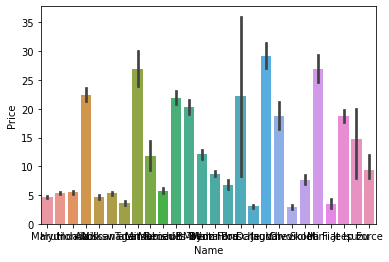

In [45]:
#Price and Name bar plot:
sns.barplot(x='Name', y='Price', data=cars)

> **Note:** This can also be applied using the [`OrdinalOrder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) transformer.  

<font color='green'>(**@**)</font> Do the above using `OrdinalOrder()`. Try to think, before coding, what's the `fit()` phase does.

In [46]:
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [47]:
ordinal = OrdinalEncoder()
data = cars[].astype(str)
x = ordinal.fit_transform(data)

# cars['cars_name_types'] = labelencoder.fit_transform(cars['Name'])
# cars['location_types'] = labelencoder.fit_transform(cars['Location'])
# cars['Fuel_n_types'] = labelencoder.fit_transform(cars['Fuel_Type'])
# cars['Transmission_types'] = labelencoder.fit_transform(cars['Transmission'])
# cars['Owner_Type_n_types'] = labelencoder.fit_transform(cars['Owner_Type'])

SyntaxError: ignored

In [ ]:
cars = cars.drop(['Name','Location','Owner_Type','Transmission','Fuel_Type'], axis=1)
cars.head()

In [ ]:
sns.barplot(x='cars_name_types', y='Price', data=cars)

## Splitting the Data

In [ ]:
X = cars.drop('Price', axis=1)
y = cars.Price

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
X_train.head(10)

In [ ]:
y_train.head(10)

# Linear Regression

This section uses the [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) method as a regressor.

> **Note:** This is a good point to look at the [Linear Regression Notebook](https://drive.google.com/drive/u/1/folders/1bzIOSPw0A9i8doZk3kZCj3j-48H_UI24)

## Fitting the Model

In [ ]:
lin_model_1 = LinearRegression().fit(X_train, y_train)

We inspect the model...

In [ ]:
list(zip(X_train.columns, lin_model_1.coef_))

In [ ]:
lin_model_1.intercept_

> **Discussion:** The coeffiecients are the prices of a column "unit". What does it mean for the various features? Was our preprocessing useful?

## Predicting with the Model

In [ ]:
y_train_pred = lin_model_1.predict(X_train)

In [ ]:
print(y_train_pred, '\n', y_train.values)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

Finally, we can score our model

> **Note:** We are not using the `score()` method because it doesn't return the RMSE.

<font color='brown'>(**#**)</font> The [`score()` method](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) uses the [$ {R}^{2} $ Score](https://en.wikipedia.org/wiki/Coefficient_of_determination).

### Validating the Model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = lin_model_1.predict(X_test)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

The test score is very close to the train score, therefore **the model is valid!** 

<font color='brown'>(**#**)</font> Pay attention to the units. Convert data back to the original units and evaluate the RMSE. You may have a look at [`log1p()`](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html) where its inverse is defined.

> **Discussion:** We will not dive any deeper with the linear model, but there are some issues that should be discussed at this point:
* The linearity assumption
    * The interpretation of the coefficients is very strict. A feature which does not comply with it will harm the model.
    * The linear model is very limited, and is rarely used in practice for complex regressions.
* Interpretation of categorical features
    * The linearity of the model interprets the encoding of the categories as linear, which may be far from reality.
    * The problem can get even worse when the categories are not ordered, then [**Dummy Variables**](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) (Like in [`LabelBinarizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)) can be used.
* Error analysis
    * Very often the errors of a model come from a specific "systematic" problem, which can simplify things when discovered.
    * Consider `sns.boxplot(x=X_train.clarity, y=y_train-y_train_pred)`
* Feature engineering
    * `table` and `depth` are already such features...
    * What about interaction features (e.g. the simple [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer)?
* Regularization 
    * There are 3 standard regularization methods for linear regression: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) & [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which is a combination of both.
    * They are less intuitive from other regularization methods, so we skip them for now.

<font color='green'>(**@**)</font> Build a model to predict the carat given `x`, `y` and `z`. Use [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to create a non linear model of degree 3 (Cubic). Try to asses which parameters are actually important by either comparing `RMSE` or normalizing the dynamic range and looking at the coefficient.

In [ ]:
sns.boxplot(x=X_train.clarity, y=y_train-y_train_pred)

# Decision Trees

This section uses the [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree) method as a regressor.

> **Note:** This is a good point to look at the [Decision Trees Regression Notebook](https://drive.google.com/drive/u/1/folders/1Y0i5AKaoos8CSQXy744qAnmEAn-DWe_N)

## First shot

### Fit the Model

In [ ]:
X = cars.drop('Price', axis=1)
y = cars.Price

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, random_state=314159)

In [ ]:
dt_model_1 = DecisionTreeRegressor().fit(X_train, y_train)

> **Reference:** The [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class.

### Inspect the Model

We write a small function to help us visualize the trees ([According to the StackOverflow anser to Python, PyDot and DecisionTree](https://stackoverflow.com/a/34219424/3121900)).

In [ ]:
def visualize_tree(model, md=5, ):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

In [ ]:
visualize_tree(dt_model_1, md=2)

> **Note:** The default hyper-parameters are set to overfitting, so we cut the tree in the figure. For actual view of the trees in this chapter, it is recommended to use [http://www.webgraphviz.com/](http://www.webgraphviz.com/) with the DOT string resulted by running the function below.

In [ ]:
def print_dot_text(model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns)
    dot_text = dot_data.getvalue()
    print(dot_text)

### Predicting with the Model

In [ ]:
y_train_pred = dt_model_1.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
MAE = mae(y_train, y_train_pred)
MAE

### Validating the Model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = dt_model_1.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.1370983551025189

## Overfitting

The fact that the **test error** is much worse than the **train error** is called [Overfitting](https://en.wikipedia.org/wiki/Overfitting). It indicates that the model learned the train data too well, and now it cannot generalize well enough for new data.

> **Reference:** 
> * [Nice intuition for overfitting by Divya Sharma](https://qr.ae/p1KiFJ) on Quora.
> * [Collection of real-life overfitting examples](https://stats.stackexchange.com/questions/128616/whats-a-real-world-example-of-overfitting).

In [ ]:
sub_diamonds = diamonds.sample(1000)
sub_X = sub_diamonds.drop('log_price', axis=1)
sub_y = sub_diamonds.log_price
sub_X_train, sub_X_test, sub_y_train, sub_y_test = split(sub_X, sub_y, random_state=1415)

For this example we will look what happens to the train error and test error when we tune the hyper-parameter called `max_leaf_nodes`.

In [ ]:
complexity = range(2, 201 , 1)
scores = pd.DataFrame(index=complexity, columns=['train', 'test'])

for leafs in complexity:
    model = DecisionTreeRegressor(max_leaf_nodes=leafs).fit(sub_X_train, sub_y_train)
    
    sub_y_train_pred = model.predict(sub_X_train)
    scores.loc[leafs, 'train'] = mse(sub_y_train_pred, sub_y_train) ** 0.5
    
    sub_y_test_pred = model.predict(sub_X_test)
    scores.loc[leafs, 'test'] = mse(sub_y_test_pred, sub_y_test) ** 0.5

> **Discussion:** Discuss the graph. Note that the effect of overfitting is more critical when the data is more diverse and noisy. The diamonds dataset is not detailed enough for this issue to be observable.

There are several methods for dealing with overfitting, including dimensionality reduction, regularization and ensemble models. Decision trees are known for having many regularization hyper-parameters, and for our next model we explore them in order to have a more regular model.

> **Discussion:** What is it that we are looking for? How are we going to know if the model is overfitted or not?

> **Warning:** *Identifying* overfitting and *dealing* with overfitting are two separate tasks. The first is performed with **cross validation** and it will be covered separately.

## Second Model

To avoid overfitting we will now experiment with **regularization**.

### Fit the Model

Next we take some of the regularization hyperparameters and add constraints to the tree.

In [ ]:
dt_model_2 = DecisionTreeRegressor(max_leaf_nodes=40, min_samples_leaf=0.01)

In [ ]:
dt_model_2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=40,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.01, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

### Inspect the Model

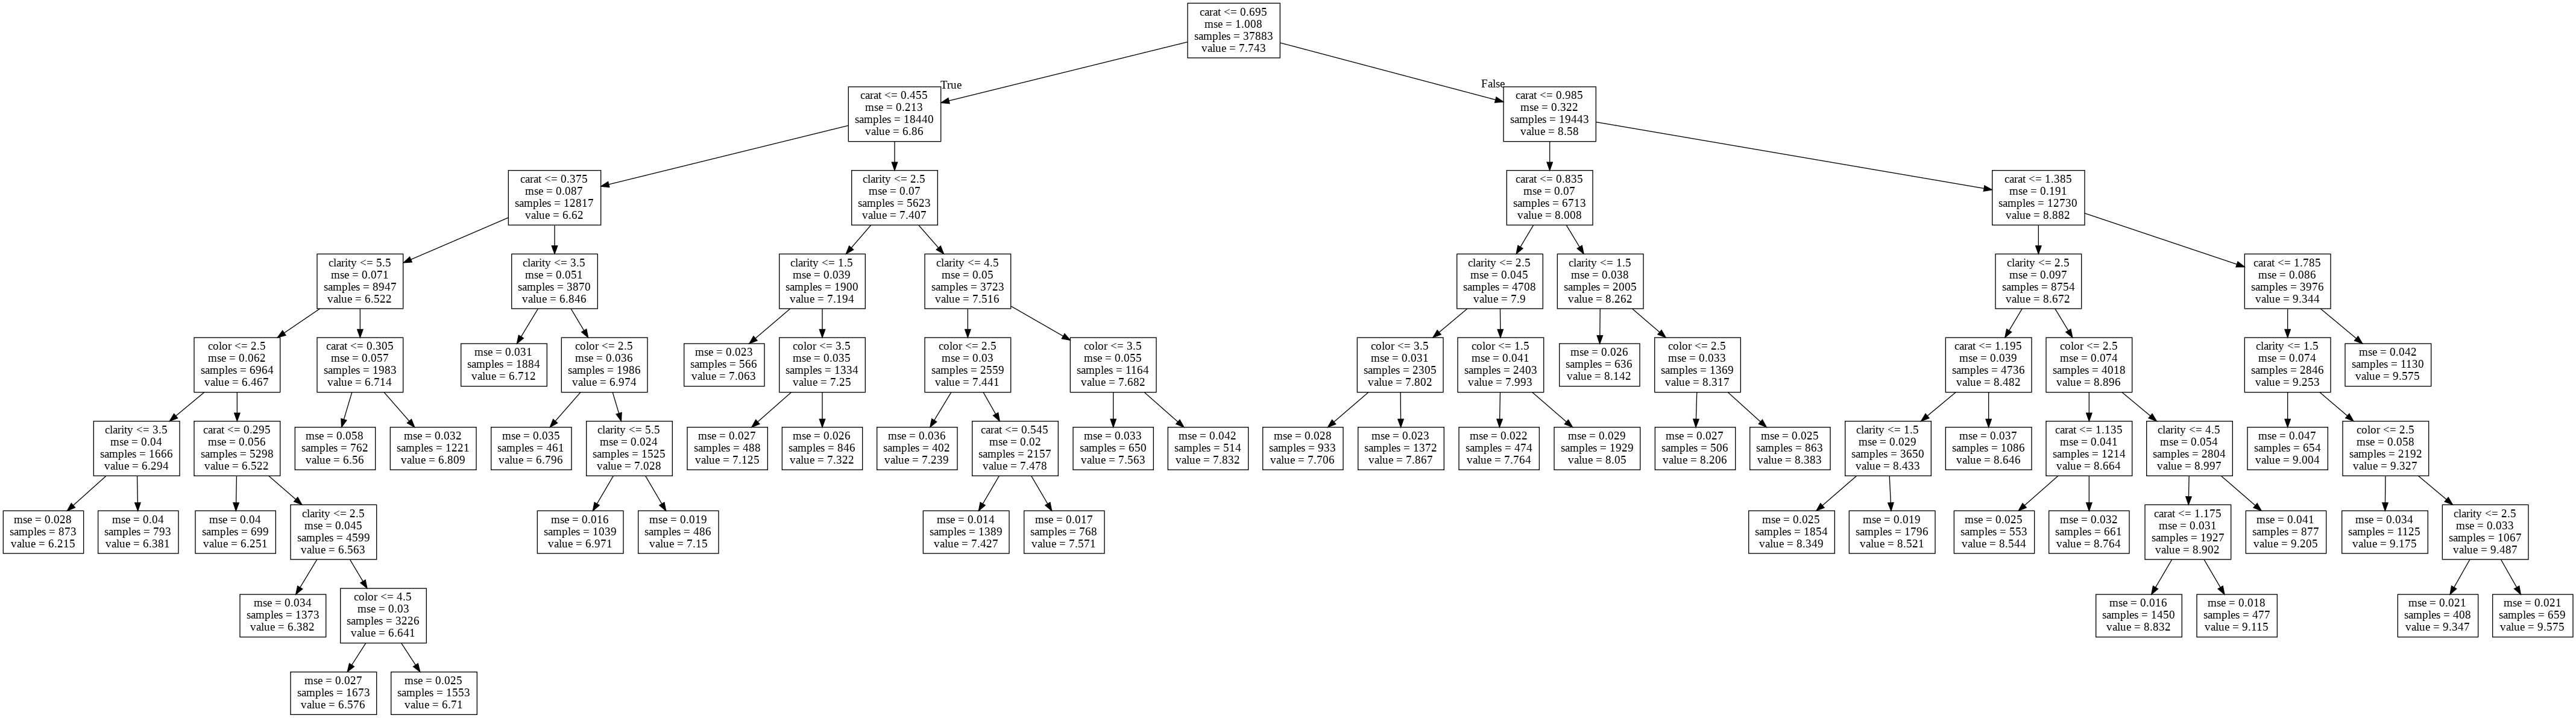

In [ ]:
visualize_tree(dt_model_2, md=10)

In [ ]:
# print_dot_text(dt_model_2)

> **Discussion:** Look at the entire tree and discuss whether it is overfitted or not.

### Predicting with the Model

In [ ]:
y_train_pred = dt_model_2.predict(X_train)

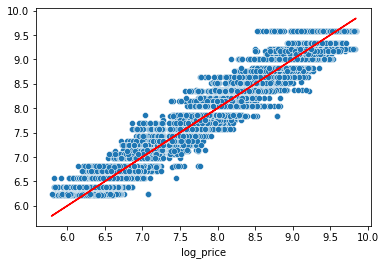

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.1682697059173441

### Validating the Model

In [ ]:
y_test_pred = dt_model_2.predict(X_test)

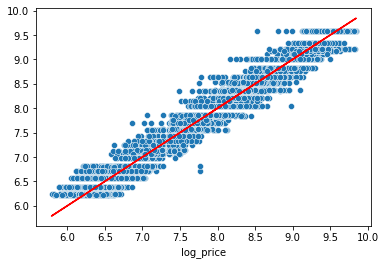

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.1685855666188134

Our model is now valid.

> **Your turn:** Try to improve the model while keeping it valid. Don't be afraid to read the documentation and choose your hyper-parameters wisely. (For your convenience - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class)

> **Discussion:** Consider again the `log1p` scaling of `price` in view of the MSE criterion.

> **Discussion:** Does changing the `random_state` hyper-parameter influence the model?

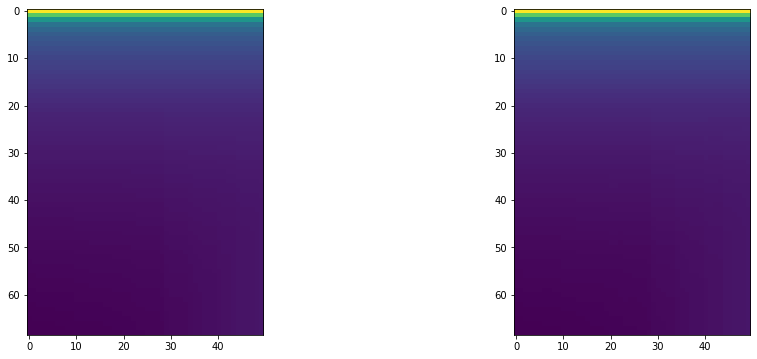

In [ ]:
#<! Analyzing different values of Hyper Parameters

vMaxLeaf = range(2, 71)
vMinSamplesLeaf = np.linspace(0.001, 0.015, num = 50)

mTrainRmse = np.zeros((len(vMaxLeaf), len(vMinSamplesLeaf)))
mTestRmse = np.zeros((len(vMaxLeaf), len(vMinSamplesLeaf)))

for ii, maxLeaf in enumerate(vMaxLeaf):
  for jj, minSamplesLeaf in enumerate(vMinSamplesLeaf):
    dtModel = DecisionTreeRegressor(max_leaf_nodes = maxLeaf, min_samples_leaf = minSamplesLeaf, random_state = 1)
    dtModel.fit(X_train, y_train)
    mTrainRmse[ii, jj] = mse(dtModel.predict(X_train), y_train, squared = False)
    mTestRmse[ii, jj] = mse(dtModel.predict(X_test), y_test, squared = False)

hF, (hA1, hA2) = plt.subplots(1, 2, figsize=(16, 6))
hA1.imshow(mTrainRmse)
hA2.imshow(mTestRmse)

# K-Nearest Neighbors

This section uses the [K Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) method as a regressor.

> **Note:** This is a good point to look at the [K-NN Regression Notebook](https://drive.google.com/drive/u/1/folders/1Dki2WvHIH6G0j79YjYLmff6NGGmOP96R).

## First Shot

In [ ]:
X_train.head(5)

,carat,cut,color,clarity,depth,table
#,,,,,,
39519,0.32,3,5,5,0.611,0.58
33261,0.42,3,6,3,0.613,0.58
48589,0.54,3,6,3,0.617,0.58
30163,0.40,1,6,2,0.636,0.57
7267,1.25,2,2,1,0.632,0.60


In [ ]:
knn_model_1 = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

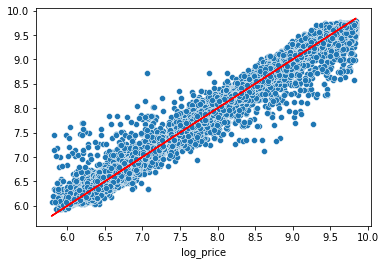

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.12812905730777066

### Validating the Model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = knn_model_1.predict(X_test)

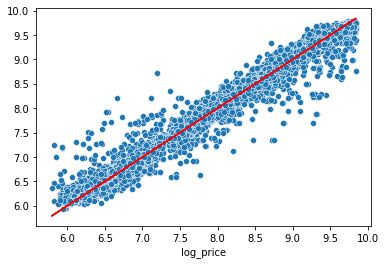

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.15017934499516308

## Scaling the Data

It is very useful to have the entire data on the same scale, and this is usually achieved with some scaling. One can scale the data in many ways, however Scikit-learn offers 3 simple scalers: [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) & [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Which one of them is the most relevant is a tricky question, and is usually rather intuitive from the nature of the feature.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

In [ ]:
X_train.head()

,carat,cut,color,clarity,depth,table
#,,,,,,
39519,0.32,3,5,5,0.611,0.58
33261,0.42,3,6,3,0.613,0.58
48589,0.54,3,6,3,0.617,0.58
30163,0.40,1,6,2,0.636,0.57
7267,1.25,2,2,1,0.632,0.60


The default metric is the Euclidean one. This means that the categorical data has much more influence.
We have two options to deal with this situation - scaling our data or modifying the metric (or both).

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,carat,cut,color,clarity,depth,table
0,0.146789,0.75,0.833333,0.714286,0.928571,0.913386
1,0.192661,0.75,1.000000,0.428571,0.931611,0.913386
2,0.247706,0.75,1.000000,0.428571,0.937690,0.913386
3,0.183486,0.25,1.000000,0.285714,0.966565,0.897638
4,0.573394,0.50,0.333333,0.142857,0.960486,0.944882


> **Notes:** 
> * The scaler is fitted on the train data only.
> * We used the `MAxAbsScaler` which gives better results (try for yourself), however it is very difficult to explain why this scaler is better.
> *The result of the scaler is a numpy array.

## Second Model

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=20).fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

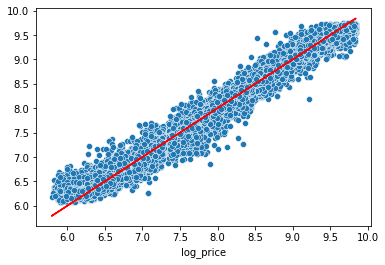

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.12635819259603978

### Validating the Model

Let's see how does the model work for the test data...

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.13816803764035493